# ----------------------------------------------------------------------
# Mutex Runs
# ----------------------------------------------------------------------


Mutex is a software package for finding mutual exclusivity and co-occurrence in cancer genes.

__To disregard the FDR and filtering method__, set:
1. leastPatientThreshold to 100
2. test_gene_threshold to 0
3. mpairPercntile to 100
4. cpairPercentile to 100

# Simuldated Data: let's see how many co-occurring pairs there are
# And how many there are after aocrrected for FDR

# Set parameters

In [11]:
mutationmatrix = '/Users/jlu96/conte/jlu/mutex/data/BRCA_wustl-som-random-123.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/BRCA_wustl-som-random-123-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 100
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 0
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 15
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. (should be default)

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

551 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


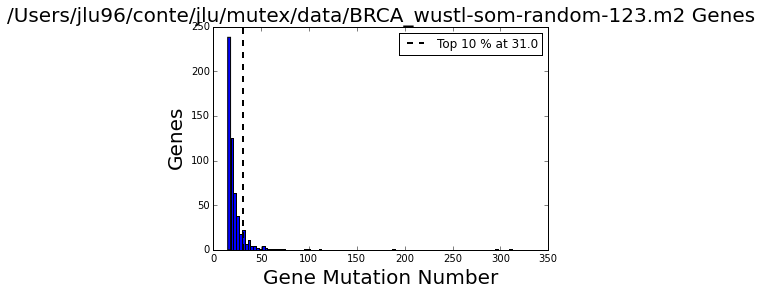

Zoomed into bottom 95 percent region


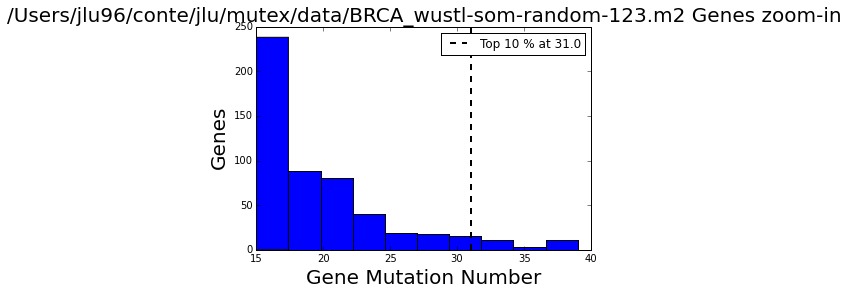


PATIENT MUTATION DISTRIBUTION


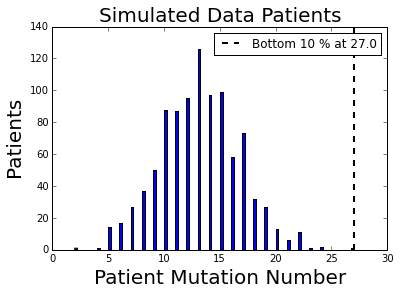

Zoomed into bottom 95 percent region


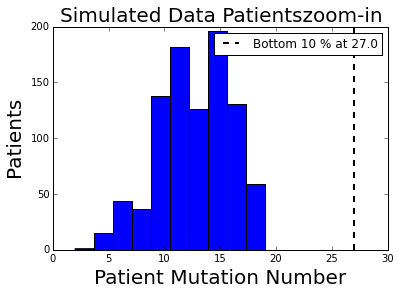

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


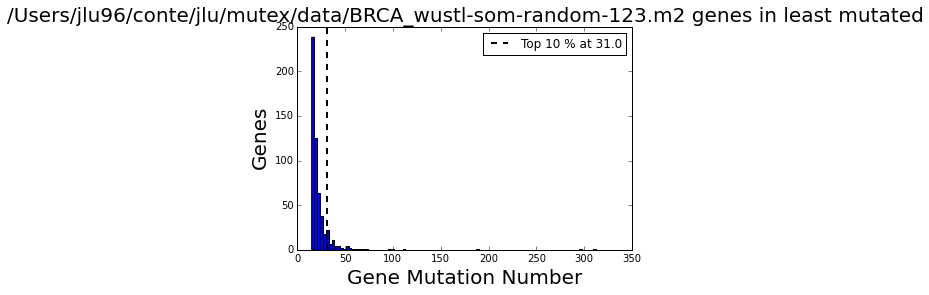


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


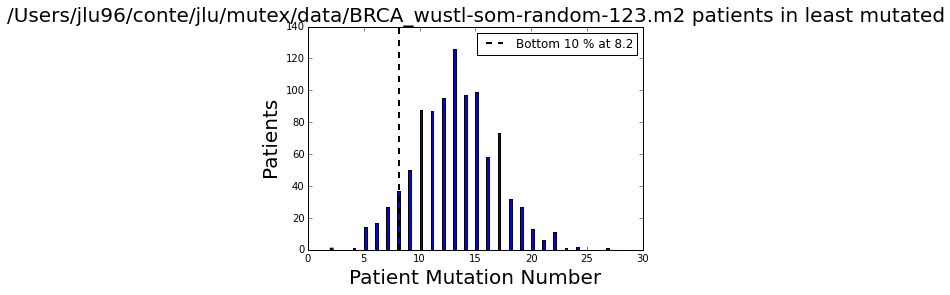

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  100  % of patients
Least mutated patients: 551 genes x 963 patients
The test gene threshold is  0 % of the least mutated patients
Test genes are mutated at least  0  in th least mutated patients
Number of test genes:  551
Number of pairs to test:  151525
Number of pairs is  151525  retrieved in time :  0.746709108353


0

In [12]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, "Simulated Data Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [3]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  32.4445960522
Testing among least mutated patients...
Finished in  166.41354084
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-random-123-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


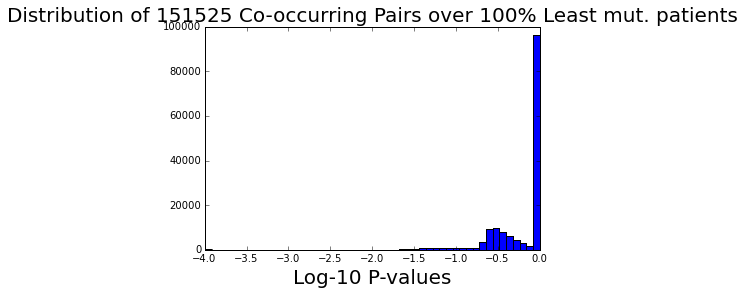

Number of co-occurring pairs under threshold 0.05 :  3417


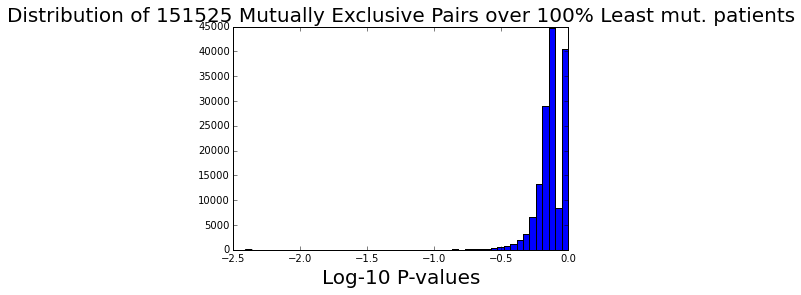

Number of mutex pairs under threshold 0.05 :  29


In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)



plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

cthreshold = 0.05
print "Number of co-occurring pairs under threshold", cthreshold, ": ", len(np.where(cpvalues < cthreshold)[0])


plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

mthreshold = 0.05
print "Number of mutex pairs under threshold", mthreshold, ": ", len(np.where(mpvalues < mthreshold)[0])

# Actual Breast Cancer SNV

# Set parameters

In [5]:
mutationmatrix = '/Users/jlu96/conte/jlu/mutex/data/BRCA_wustl-som.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/BRCA_wustl-som-compare-simulated-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 100
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 0
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 15
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. (should be default)

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

542 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


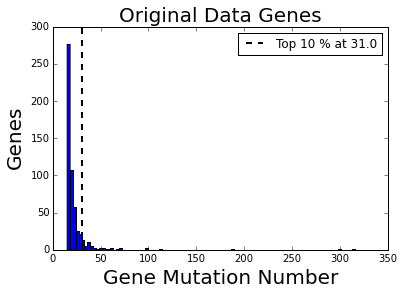

Zoomed into bottom 95 percent region


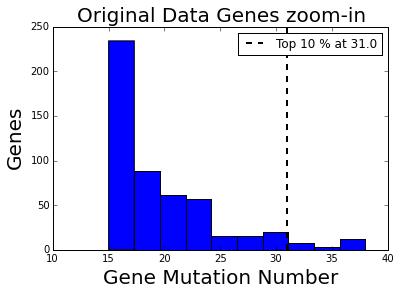


PATIENT MUTATION DISTRIBUTION


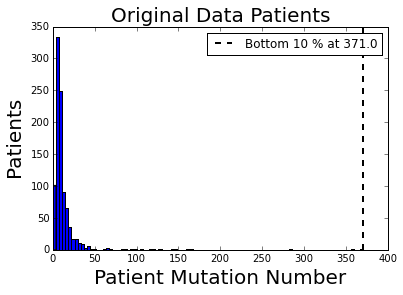

Zoomed into bottom 95 percent region


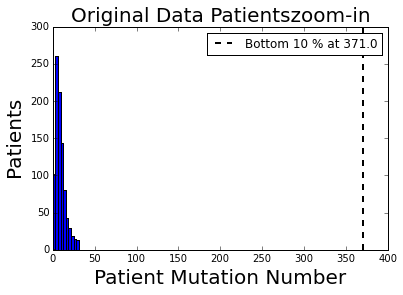

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


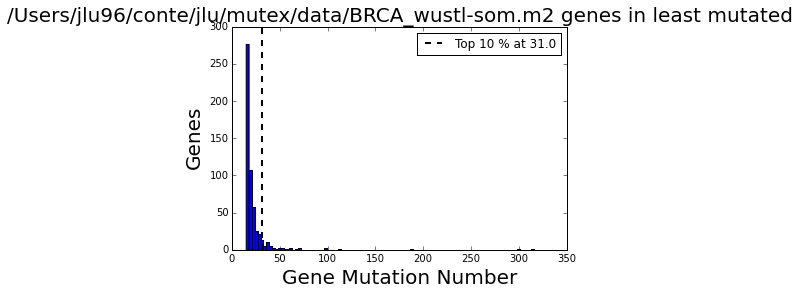


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


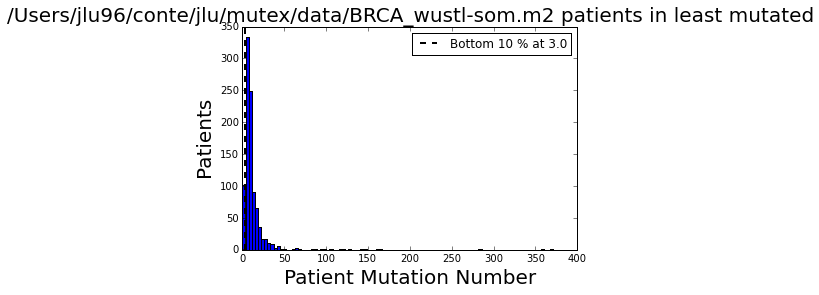

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  100  % of patients
Least mutated patients: 542 genes x 963 patients
The test gene threshold is  0 % of the least mutated patients
Test genes are mutated at least  0  in th least mutated patients
Number of test genes:  542
Number of pairs to test:  146611
Number of pairs is  146611  retrieved in time :  1.16704201698


0

In [9]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename="Original Data Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, "Original Data Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [7]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  94.3168900013
Testing among least mutated patients...
Finished in  232.230377913
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-compare-simulated-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

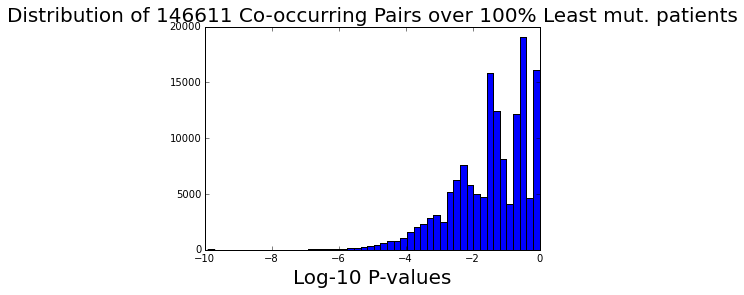

Number of co-occurring pairs under threshold 0.05 :  75809
Number of co-occurring pairs under threshold 3.41038530533e-07 :  128


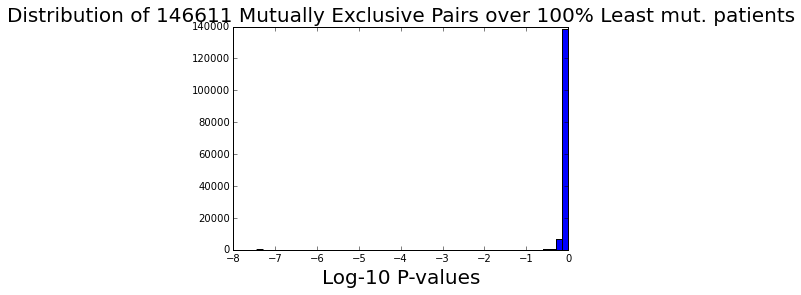

Number of mutex pairs under threshold 0.05 :  8


In [13]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)



plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

cthreshold = 0.05
print "Number of co-occurring pairs under threshold", cthreshold, ": ", len(np.where(cpvalues < cthreshold)[0])
fwer_cthreshold = 0.05 / len(cpvalues)
print "Number of co-occurring pairs under threshold", fwer_cthreshold, ": ", len(np.where(cpvalues < fwer_cthreshold)[0])


plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

mthreshold = 0.05
print "Number of mutex pairs under threshold", mthreshold, ": ", len(np.where(mpvalues < mthreshold)[0])

# Permuted Matrix of Breast Cancer SNV

# Set parameters

In [22]:
mutationmatrix = '/Users/jlu96/conte/jlu/mutex/data/BRCA_wustl-som-comet-permuted-matrices/permuted-matrix-1.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/BRCA_wustl-som-permuted-matrix-compare-simulated-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 100
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 0
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 15
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. (should be default)

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

537 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


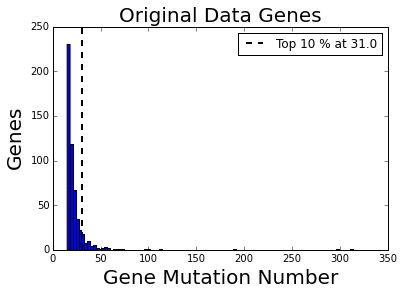

Zoomed into bottom 95 percent region


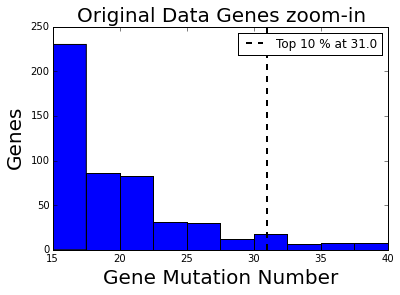


PATIENT MUTATION DISTRIBUTION


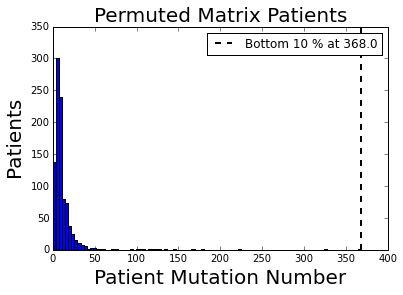

Zoomed into bottom 95 percent region


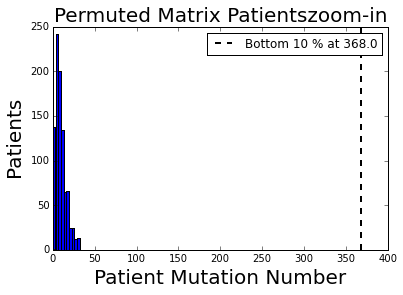

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


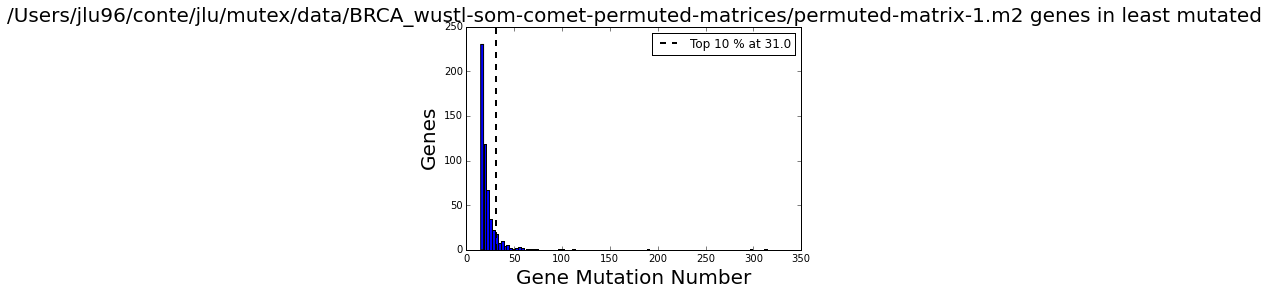


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


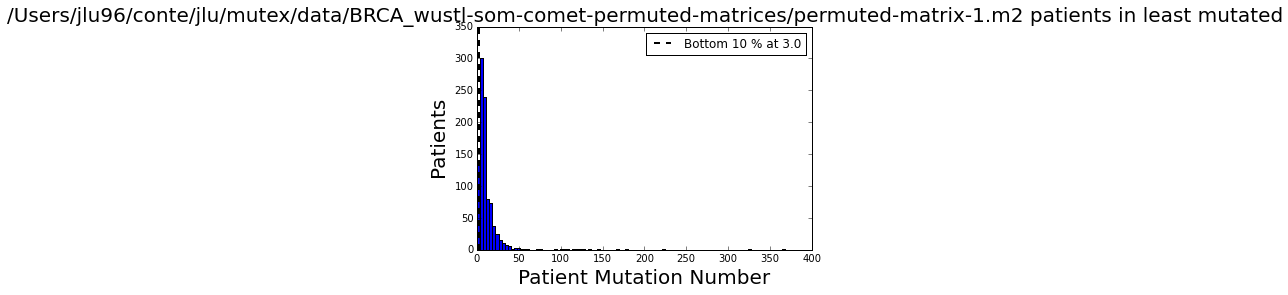

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  100  % of patients
Least mutated patients: 537 genes x 963 patients
The test gene threshold is  0 % of the least mutated patients
Test genes are mutated at least  0  in th least mutated patients
Number of test genes:  537
Number of pairs to test:  143916
Number of pairs is  143916  retrieved in time :  0.870980978012


0

In [26]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename="Original Data Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, "Permuted Matrix Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [24]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  39.7195358276
Testing among least mutated patients...
Finished in  153.341010094
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-permuted-matrix-compare-simulated-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

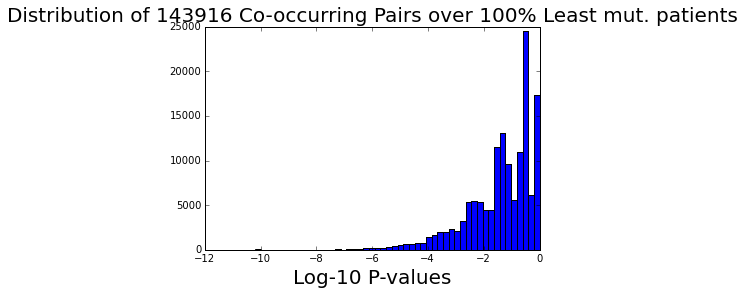

Number of co-occurring pairs under threshold 0.05 :  65274
Number of co-occurring pairs under threshold 3.47424886739e-07 :  332


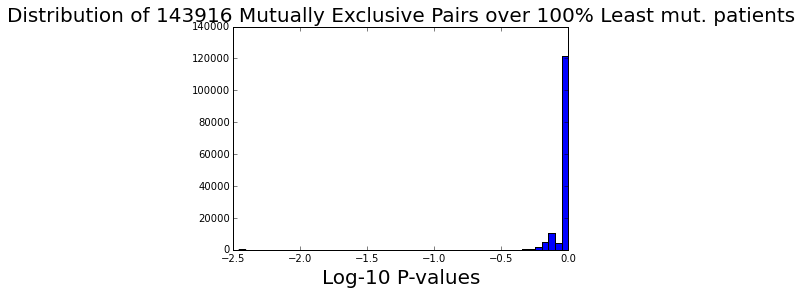

Number of mutex pairs under threshold 0.05 :  2


In [25]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)



plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

cthreshold = 0.05
print "Number of co-occurring pairs under threshold", cthreshold, ": ", len(np.where(cpvalues < cthreshold)[0])
fwer_cthreshold = 0.05 / len(cpvalues)
print "Number of co-occurring pairs under threshold", fwer_cthreshold, ": ", len(np.where(cpvalues < fwer_cthreshold)[0])


plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

mthreshold = 0.05
print "Number of mutex pairs under threshold", mthreshold, ": ", len(np.where(mpvalues < mthreshold)[0])

# Prostate Copy Number

# Set parameters

In [11]:
mutationmatrix = '/Users/jlu96/conte/jlu/mutex/data/PRAD_broad-cna-gl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/PRAD_broad/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/PRAD_broad-cna-gl-no-distance-threshold-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 100
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 40
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 0
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. (should be default)

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

49494 genes x 420 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


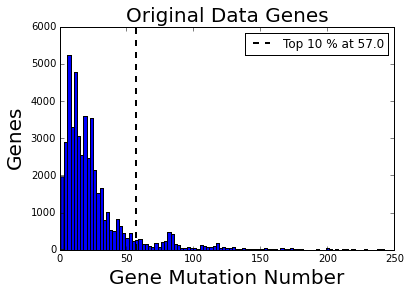

Zoomed into bottom 95 percent region


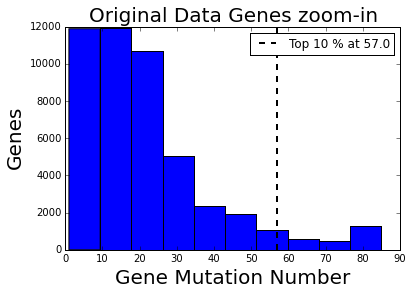


PATIENT MUTATION DISTRIBUTION


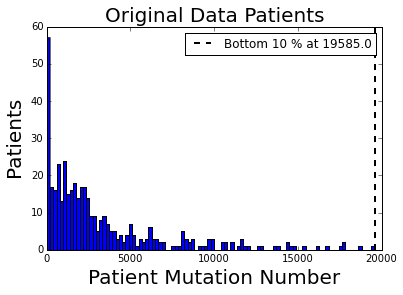

Zoomed into bottom 95 percent region


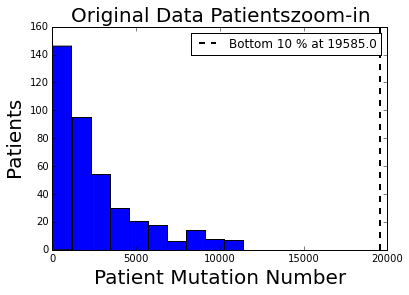

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


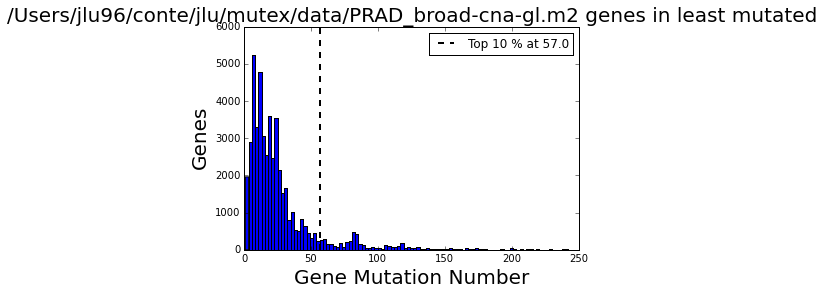


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


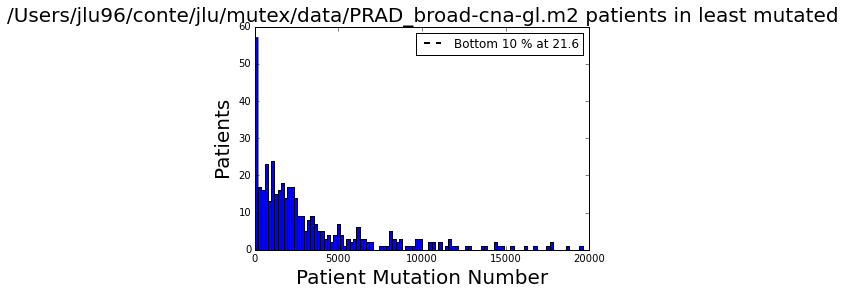

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  100  % of patients
Least mutated patients: 49494 genes x 420 patients
The test gene threshold is  40 % of the least mutated patients
Test genes are mutated at least  168  in th least mutated patients
Number of test genes:  393
Number of pairs to test:  77028
Number of pairs is  77028  retrieved in time :  562.510282993


0

In [12]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename="Original Data Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, "Original Data Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [19]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

fieldnames.insert(3, 'Gene1Loc')
fieldnames.insert(3, 'Gene0Loc')


for pair in pairsdict:
    if pairsdict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = pairsdict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if pairsdict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = pairsdict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(pairsdict[pair]['Gene0'])
    pairsdict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(pairsdict[pair]['Gene1'])
    pairsdict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    pairsdict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    pairsdict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')

Getting normal statistics...
Finished in  59.8592500687
Testing among least mutated patients...
Finished in  92.454750061
All pairs tested in least mutated patients written to  output/PRAD_broad-cna-gl-no-distance-threshold-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

In [20]:
orderedpairs = sorted(pairsdict.keys(), key = lambda entry: pairsdict[pair]['1CBinomProb0'])
met.writeanydict(pairsdict, new_cpairfile, fieldnames=fieldnames, orderedkeys=orderedpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile

updated with segment info  output/PRAD_broad-cna-gl-no-distance-threshold--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/PRAD_broad-cna-gl-no-distance-threshold--cpairs-min_cohort_filtered.txt


# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


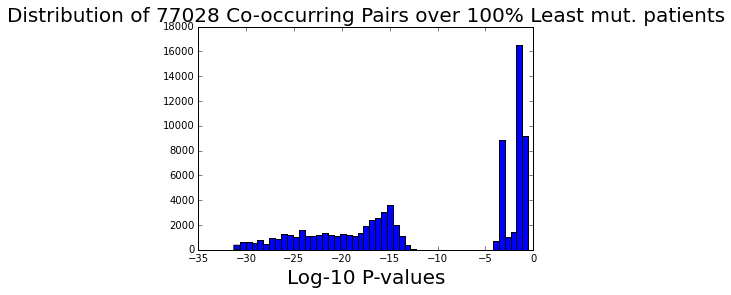

Number of co-occurring pairs under threshold 0.05 :  63107
Number of co-occurring pairs under threshold 6.49114607675e-07 :  39412


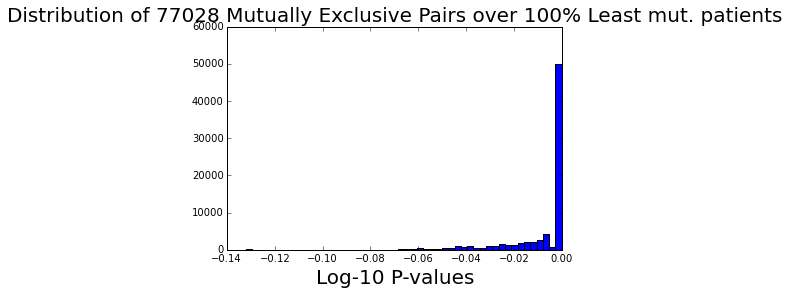

Number of mutex pairs under threshold 0.05 :  0


In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)



plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

cthreshold = 0.05
print "Number of co-occurring pairs under threshold", cthreshold, ": ", len(np.where(cpvalues < cthreshold)[0])
fwer_cthreshold = 0.05 / len(cpvalues)
print "Number of co-occurring pairs under threshold", fwer_cthreshold, ": ", len(np.where(cpvalues < fwer_cthreshold)[0])


plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

mthreshold = 0.05
print "Number of mutex pairs under threshold", mthreshold, ": ", len(np.where(mpvalues < mthreshold)[0])